In [1]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact_manual
import ipywidgets as wd

from os import system

''' GLOBAL CONSTANTS '''
PI = 3.141592
BOLTZMANN = 1.380649E-23 #N·m/K
TEMP = 25 + 273.15 #K
g = 9.81 #m/s²

# Calculate the attachment coefficient via filtration theory

## Our model:

\begin{equation}
\begin{array}{rr}
    \dfrac{\partial C}{\partial t} + \dfrac{1}{\theta}\:\vec{q} \cdot \nabla C  - \nabla \cdot (D_T\nabla C) =& - k_{\rm att}C + \dfrac{1}{\theta}k_{\rm det}S -\lambda_{\rm aq} C\\
    \\
    \dfrac{1}{\theta}\dfrac{\partial S}{\partial t} =& k_{\rm att}C - \dfrac{1}{\theta}k_{\rm det}S -\lambda_{\rm im} S\\
\end{array}
\end{equation}

**Concentrations**
- $C$ : concentration of infective viruses in the water phase
- $S$ : concentration of infective viruses attached to the solid phase

**Reaction rates**
- $k_{\rm att}$ : attachment rate (C -> S)
- $k_{\rm det}$ : detachment rate (S -> C)
- $\lambda_{\rm aq}$ : decay rate while in aqueous phase (C -> X)
- $\lambda_{\rm im}$ : decay rate while attached to solid phase (S -> X)

**Advection/diffusion parameters**
- $\vec{q}$ : darcy Flow
- $t$ : time
- $\theta$ : porosity
- $D_T$ : Dispersion coefficient

### Dispersion coefficient $D_T$

$ D_T = D_m + \alpha_LU^n $

- $D_m$ : molecular diffusion coefficient
- $\alpha_L$ : longitudinal dispersion coefficient
- $U$ : intersticial flow velocity
- $n$ : empirical fitting exponent

*Neglecting transversal dispersion*b

In [2]:
def dispCoef(D_m,alpha_L,U,n=1.0): 
    return D_m + alpha_L*(U**n)

### Intersticial flow velocity

Pore-water velocity from the darcy velocity:

$U = \dfrac{q}{\theta}$

In [3]:
def poreVel(q,theta): 
    return q/theta

### Molecular diffusion coefficient $D_m$

From the Stokes-Einstein equation:

$D_m = \dfrac{k_BT}{3\pi\eta d_p}$

- $T$ : Temperature
- $k_B$ : Boltzmann constant
- $\eta$ : water dynamic viscosity
- $d_p$ : (virus) particle diameter
_____

In [4]:
def molecularDiff(visco,dp): 
    return (BOLTZMANN*TEMP)/(3*PI*visco*dp)

## Attachment rate coefficient: $k_{\rm att}$

\begin{equation}
    k_{\rm att} = \dfrac{3 }{2d}(1-\theta)\alpha||\vec{q}||\eta_0
\end{equation}

- $d$ : collector diameter (soil grain size)
- $\alpha$ : collision/attachment efficiency
- $\eta_0$ : collector efficiency

In [5]:
def attachmentRate(dc,theta,alpha,q,eta0): 
    return (3*(1-theta)*alpha*q*eta0)/(2*dc)

### Collision/attachment efficiency $\alpha$

$\alpha = 1.0$ for **favorable attachment conditions**, e.g., opposed electrostatic charges between the collector (soil grains) and the particles.

For **infavorable conditions** such as the movement of viruses in soils, $\alpha < 1.0$. In these cases, it will be dependant of the isoelectric point of the particles and the soil matrix. 

### The collector efficiency: $\eta_0$

$
    \eta_0 = \overbrace{\eta_{\rm D}}^\text{Diffusion} + \underbrace{\eta_{\rm I}}_\text{Interception} + \overbrace{\eta_{\rm G}}^\text{Grav. deposition}
$

In [6]:
def collectorEff(etaD,etaI,etaG):
    return etaD + etaI + etaG

Each term is approximated by Tufenkji & Elimelech (2004) [\[10.1021/es034049r\]](https://pubs.acs.org/doi/10.1021/es034049r):

$
\begin{array}{rl}
    \eta_{\rm D} =& 2.4 A_s^{1/3}N_{\rm R}^{-0.081}N_{\rm Pe}^{-0.175}N_{\rm vdW}^{0.052}\\
    \\
    \eta_{\rm I} =& 0.55 A_sN_{\rm R}^{1.55}N_{\rm Pe}^{-0.125}N_{\rm vdW}^{0.125}\\
    \\
    \eta_{\rm G} =& 0.475 N_{\rm gr}^{1.11} N_{\rm R}^{-1.35}N_{\rm Pe}^{-1.11}N_{\rm vdW}^{0.053}\\
\end{array}
$

In [7]:
def collectorEfficiency_Diffusion(A_s,N_R,N_Pe,N_vdW):
    return 2.40 * (A_s**(1./3.)) * (N_R**-0.081) * (N_Pe**-0.175) * (N_vdW**0.052)

def collectorEfficiency_Interception(A_s,N_R,N_Pe,N_vdW):
    return 0.55 * A_s * (N_R**1.55) * (N_Pe**-0.125) * (N_vdW**0.125)

def collectorEfficiency_GDeposition(N_gr,N_R,N_Pe,N_vdW):
    return 0.475 * (N_gr**1.11)   * (N_R**-1.35)  * (N_Pe**-1.11)  * (N_vdW**0.053)

All these collector efficiencies come from **non-dimensional numbers** that defined as follows:

- $
\begin{array}{lcl}
    A_s = \dfrac{2(1-s^{5/3})}{2-3s^{1/3}+3s^{5/3}-2s^2} &\quad& s = 1-\theta
\end{array}
$

In [8]:
def happelParameter(theta):
    s = 1-theta
    s53 = s**(5./3.)
    s13 = s**(1./3.)
    s21 = s**2
    return (2*(1-s53))/(2 - (3*s13) + (3*s53) - (2*s21))

**Size ratio:**

- $N_{\rm R} = \dfrac{d_p}{d}$

In [9]:
def noDim_SizeRatio(dp,dc):
    return dp/dc

**Péclet number:**

- $N_{\rm Pe} = \dfrac{Ud}{D_m}$

In [10]:
def noDim_Péclet(U,dc,Dm):
     return U*dc/Dm

**van der Waals number:**

- $N_{\rm vdW} = \dfrac{A}{k_BT}$

In [11]:
def noDim_vanderWaals(A):
    return A/(BOLTZMANN*TEMP)

**Gravitational number:**

- $N_{\rm gr} = \dfrac{4\pi r_p^4 (\rho_p - \rho_f)g}{3k_BT} = \dfrac{\pi d_p^4 (\rho_p - \rho_f)g}{12k_BT}$

In [12]:
def noDim_Gravitational(dp,rhof,rhop):
    return (PI*(dp**4)*(rhop-rhof)*g)/(12.*BOLTZMANN*TEMP)

_________

# Attachment rate $k_{\rm att}$ as a function of particle size

In [13]:
'''CASE CONSTANTS'''
#Porosity
theta = 0.35 # adim

#Collector diameter
dc = 2.0E-3 # 2mm << sand

#Hamaker constant
A = 5.0E-21 # J = N·m

#Water dynamic viscosity
viscosity = 0.0008891 # N·s/m²

#Densities
water_density = 997.05 # kg/m³
particle_density = 1050.0 # kg/m³ 

#Collision/attachment efficiency
alpha = 1.00 # adim << favorable conditions

#Darcy flow velocity
q = 0.0001 # m/s 

In [14]:
def kattFromdp(dp):

    #Molecular diffusion
    Dm  = molecularDiff(viscosity,dp)
    
    #Pore water velocity
    U   = poreVel(q,theta)
    
    #Non-dimensional numbers
    As  = happelParameter(theta)
    NR  = noDim_SizeRatio(dp,dc)
    NPe = noDim_Péclet(U,dc,Dm)
    NvW = noDim_vanderWaals(A)
    NGr = noDim_Gravitational(dp,water_density,particle_density)
    
    #Collector efficiency
    etaD = collectorEfficiency_Diffusion(As,NR,NPe,NvW)
    etaI = collectorEfficiency_Interception(As,NR,NPe,NvW)
    etaG = collectorEfficiency_GDeposition(NGr,NR,NPe,NvW)
    eta0 = collectorEff(etaD,etaI,etaG)
    
    #Attachment rate
    kAtt = attachmentRate(dc,theta,alpha,q,eta0)
    return kAtt

## Calculator for a single particle size value

In [15]:
dpSlider = wd.FloatLogSlider(value=100.0E-9,base=10.,min=-9,max=-2,description="Part. size [m]")
interact_manual(kattFromdp,dp=dpSlider);

interactive(children=(FloatLogSlider(value=1e-07, description='Part. size [m]', max=-2.0, min=-9.0), Button(de…

## Plot particle size v. attachment rate 

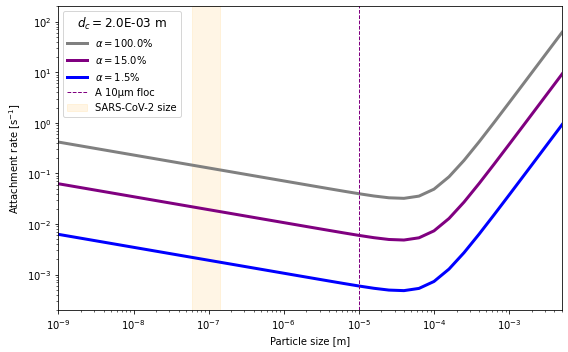

In [16]:
dp = np.power(10.,np.arange(-9,-2,0.2))
dc = 2.0E-3 # 2mm << sand

dpVirus = [60.0E-9, 140.0E-9] #Measured sarscov2
dpFloc = 10.0E-6 #A floc?

plt.figure(figsize=(8,5),facecolor="white")
ax1 = plt.subplot(1,1,1)
## Efficiency 100%
alpha = 1.00
K = kattFromdp(dp)
ax1.plot(dp,K,lw=3,c="gray",\
         label="$\\alpha = $"+"{:.1f}%".format(alpha*100))
## Different efficiencies
alpha = 0.15
K = kattFromdp(dp)
ax1.plot(dp,K,lw=3,c="purple",\
         label="$\\alpha = $"+"{:.1f}%".format(alpha*100))

alpha = 0.015
K = kattFromdp(dp)
ax1.plot(dp,K,lw=3,c="blue",\
         label="$\\alpha = $"+"{:.1f}%".format(alpha*100))

## Vertical lines
ax1.axvline(x=dpFloc,\
            label="A 10μm floc",\
            ls="dashed",lw=1,c="purple")

## Vertical spans
ax1.axvspan(dpVirus[0],dpVirus[1],\
            label="SARS-CoV-2 size",\
            color="orange",alpha=0.10)


## Miscelaneous
ax1.set_yscale("log")
ax1.set_xscale("log")
ax1.set_ylabel("Attachment rate [s$^{-1}$]")
ax1.set_xlabel("Particle size [m]")
ax1.set_xlim(1.0E-9,5.0E-3)
ax1.set_ylim(2.0E-4,2.0E+2)

## Legend
ax1.legend(loc="best",\
           title="$d_c = $" + "{:.1E} m".format(dc),\
           title_fontsize="large")

plt.tight_layout()
plt.show()

## Plot collector size v. attachment rate 

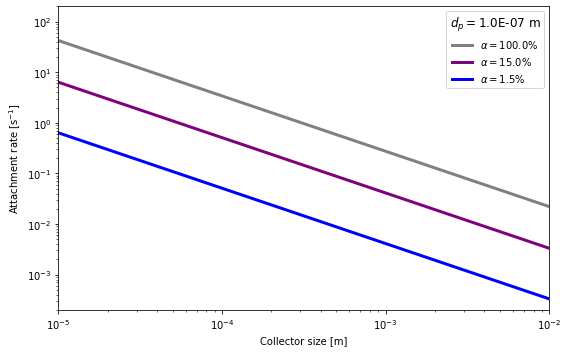

In [17]:
dc = np.power(10.,np.arange(-5,0,0.2))
dp = 100.0E-9 #A sarscov2?

plt.figure(figsize=(8,5),facecolor="white")
ax1 = plt.subplot(1,1,1)
## Efficiency 100%
alpha = 1.00
K = kattFromdp(dp)
ax1.plot(dc,K,lw=3,c="gray",\
         label="$\\alpha = $"+"{:.1f}%".format(alpha*100))
## Different efficiencies
alpha = 0.15
K = kattFromdp(dp)
ax1.plot(dc,K,lw=3,c="purple",\
         label="$\\alpha = $"+"{:.1f}%".format(alpha*100))

alpha = 0.015
K = kattFromdp(dp)
ax1.plot(dc,K,lw=3,c="blue",\
         label="$\\alpha = $"+"{:.1f}%".format(alpha*100))

## Miscelaneous
ax1.set_yscale("log")
ax1.set_xscale("log")
ax1.set_ylabel("Attachment rate [s$^{-1}$]")
ax1.set_xlabel("Collector size [m]")
ax1.set_xlim(1.0E-5,1.0E-2)
ax1.set_ylim(2.0E-4,2.0E+2)

## Legend
ax1.legend(loc="best",\
           title="$d_p = $" + "{:.1E} m".format(dp),\
           title_fontsize="large")

plt.tight_layout()
plt.show()

## Plot collector size v. attachment rate 

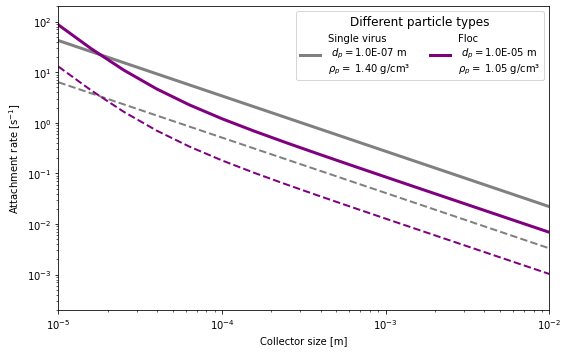

In [18]:
dc = np.power(10.,np.arange(-5,0,0.2))

plt.figure(figsize=(8,5),facecolor="white")
ax1 = plt.subplot(1,1,1)

## Individual virus
alpha = 1.00
dp = 100.0E-9 #A sarscov2
particle_density=1400
K = kattFromdp(dp)
ax1.plot(dc,K,lw=3,c="gray",\
         label="Single virus\n $d_p = $" + "{:.1E} m".format(dp)\
         + "\n$\\rho_p = $" + " {:.2f} g/cm³".format(particle_density/1000))

dp = 10.0E-6 #A biomass floc
particle_density=1050
K = kattFromdp(dp)
ax1.plot(dc,K,lw=3,c="purple",\
         label="Floc\n $d_p = $" + "{:.1E} m".format(dp)\
         + "\n$\\rho_p = $" + " {:.2f} g/cm³".format(particle_density/1000))

## Individual virus
alpha = 0.15
dp = 100.0E-9 #A sarscov2
particle_density=1400
K = kattFromdp(dp)
ax1.plot(dc,K,lw=2,c="gray",ls='dashed')

dp = 10.0E-6 #A biomass floc
particle_density=1050
K = kattFromdp(dp)
ax1.plot(dc,K,lw=2,c="purple",ls='dashed')


## Miscelaneous
ax1.set_yscale("log")
ax1.set_xscale("log")
ax1.set_ylabel("Attachment rate [s$^{-1}$]")
ax1.set_xlabel("Collector size [m]")
ax1.set_xlim(1.0E-5,1.0E-2)
ax1.set_ylim(2.0E-4,2.0E+2)

## Legend
ax1.legend(loc="best",\
           title="Different particle types",\
           title_fontsize="large",\
           ncol=2)

plt.tight_layout()
plt.show()

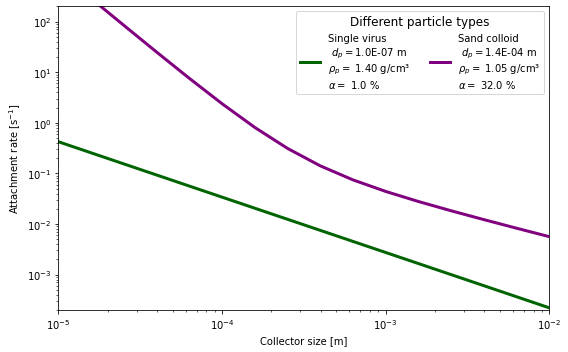

In [19]:
dc = np.power(10.,np.arange(-5,0,0.2))


plt.figure(figsize=(8,5),facecolor="white")
ax1 = plt.subplot(1,1,1)

## Individual virus
alpha = 0.01 #Over SiO2
dp = 100.0E-9 #A sarscov2
particle_density=1400
K = kattFromdp(dp)
ax1.plot(dc,K,lw=3,c="darkgreen",\
         label="Single virus\n $d_p = $" + "{:.1E} m".format(dp)\
         + "\n$\\rho_p = $" + " {:.2f} g/cm³".format(particle_density/1000)
         + "\n$\\alpha = $" + " {:.1f} %".format(alpha*100))

## A sand colloid
alpha = 0.32 #Check ren & packman - 2000
dp = 137.0E-6 #A #100 sand colloid
particle_density=1050
K = kattFromdp(dp)
ax1.plot(dc,K,lw=3,c="purple",\
         label="Sand colloid\n $d_p = $" + "{:.1E} m".format(dp)\
         + "\n$\\rho_p = $" + " {:.2f} g/cm³".format(particle_density/1000)
         + "\n$\\alpha = $" + " {:.1f} %".format(alpha*100))

## Miscelaneous
ax1.set_yscale("log")
ax1.set_xscale("log")
ax1.set_ylabel("Attachment rate [s$^{-1}$]")
ax1.set_xlabel("Collector size [m]")
ax1.set_xlim(1.0E-5,1.0E-2)
ax1.set_ylim(2.0E-4,2.0E+2)

## Legend
ax1.legend(loc="best",\
           title="Different particle types",\
           title_fontsize="large",\
           ncol=2)

plt.tight_layout()
plt.show()